In [1]:
from rfdetr import RFDETRMedium
import os

In [2]:
dataset_location = "./dataset/video_short"

In [3]:
model = RFDETRMedium(pretrain_weights="./output/checkpoint_best_ema.pth")
model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


num_classes mismatch: pretrain weights has 0 classes, but your model has 90 classes
reinitializing detection head with 0 classes


Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [4]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_location}/test",
    annotations_path=f"{dataset_location}/test/_annotations.coco.json",
)

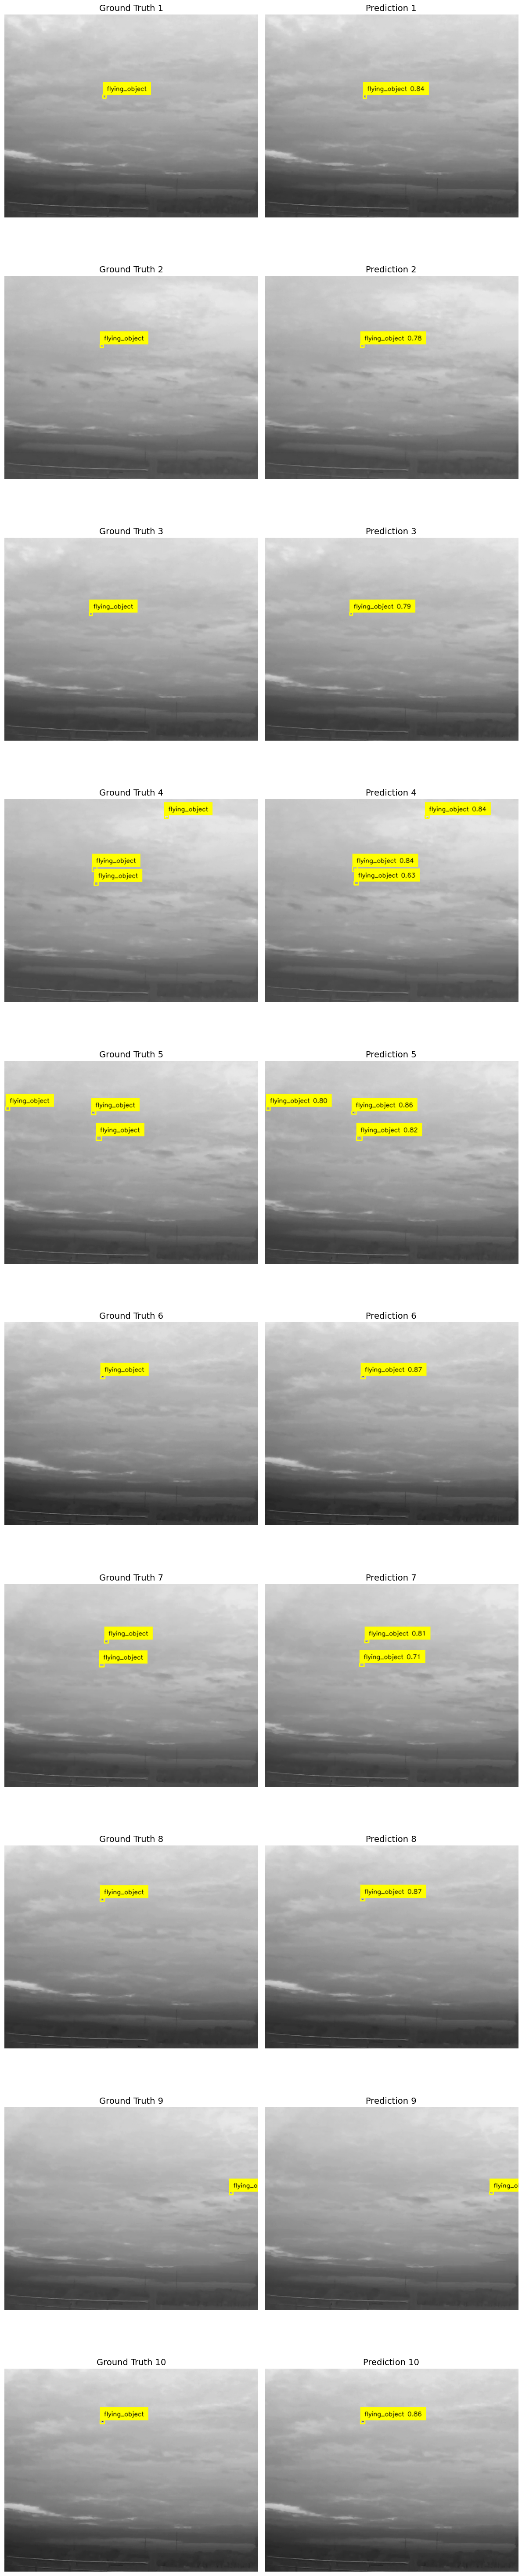

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

images = []
titles = []

# Reduce number of images if needed for speed
num_samples = min(10,len(ds))

for i in range(num_samples):
    path, image, annotations = ds[i]
    image = Image.open(path)

    # Get predictions
    detections = model.predict(image, threshold=0.5)

    # Calculate visualization parameters
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
    color = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
        "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])

    # Annotators
    bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale
    )

    # Labels
    annotations_labels = [f"{ds.classes[class_id]}" for class_id in annotations.class_id]
    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    # Annotated images
    annotation_image = bbox_annotator.annotate(image.copy(), annotations)
    annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

    detections_image = bbox_annotator.annotate(image.copy(), detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    images.extend([annotation_image, detections_image])
    titles.extend([f"Ground Truth {i+1}", f"Prediction {i+1}"])

# Plotting (larger images)
cols = 2
rows = num_samples
fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))  # Increase figsize as needed

if rows == 1:
    axes = [axes]  # Ensure iterable if only one row

for idx, ax in enumerate(axes.flat if isinstance(axes, np.ndarray) else axes):
    ax.imshow(images[idx])
    ax.set_title(titles[idx], fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()